## Matviienko Kateryna, DA-11, Lab 2

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [8]:
train_data = pd.read_csv('C:\\Users\\Катя\\Desktop\\application_train.csv')
test_data = pd.read_csv('C:\\Users\\Катя\\Desktop\\application_test.csv')

In [ ]:
print(train_data.shape, test_data.shape)
train_data.head()

In [ ]:
#train_data.describe()
#train_data.describe(include='all')
#train_data.info()
#train_data.median()
#train_data.mean()
train_data.sample(3)

### Перевіримо, чи є в датасеті відсутні значення або дублікати

In [ ]:
print((train_data.isnull().mean() * 100).sort_values(ascending=False).head())

In [9]:
data = train_data.dropna(axis='columns')
print(data.shape)

(307511, 55)


In [ ]:
print((data.isnull().mean() * 100).sort_values(ascending=False).head())

In [ ]:
if train_data.duplicated().any():
    print("train_data.duplicated().")

In [23]:
#print(train_data.corrwith(train_data["TARGET"], drop=True))

### Побудуємо розподіл Target 

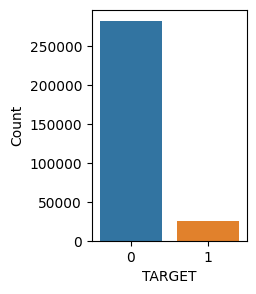

Number of "0": 282686
Number of "1": 24825


In [640]:
plt.figure(figsize=(2, 3))
sns.countplot(x='TARGET', data=train_data)
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.show()

print(f'Number of "0": {train_data["TARGET"].value_counts().get(0, 0)}')
print(f'Number of "1": {train_data["TARGET"].value_counts().get(1, 0)}')

### Розмежуємо категоріальні, числові та булеві дані

In [10]:
features = data.columns[data.notnull().all()]

boolean_features = data[[col for col in features if data[col].nunique() == 2]].columns
numerical_features = data[[col for col in features if data[col].dtype in ['float64', 'int64'] and col not in boolean_features]].columns
categorical_features = data[[col for col in features if data[col].dtype == 'object' and col not in boolean_features]].columns

print(f'\nNumerical: {numerical_features}\n\nBoolean: {boolean_features}\n\nCategorical: {categorical_features}\n')


Numerical: Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START'],
      dtype='object')

Boolean: Index(['TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
  

### Побудуємо гістограми для категоріальних значень

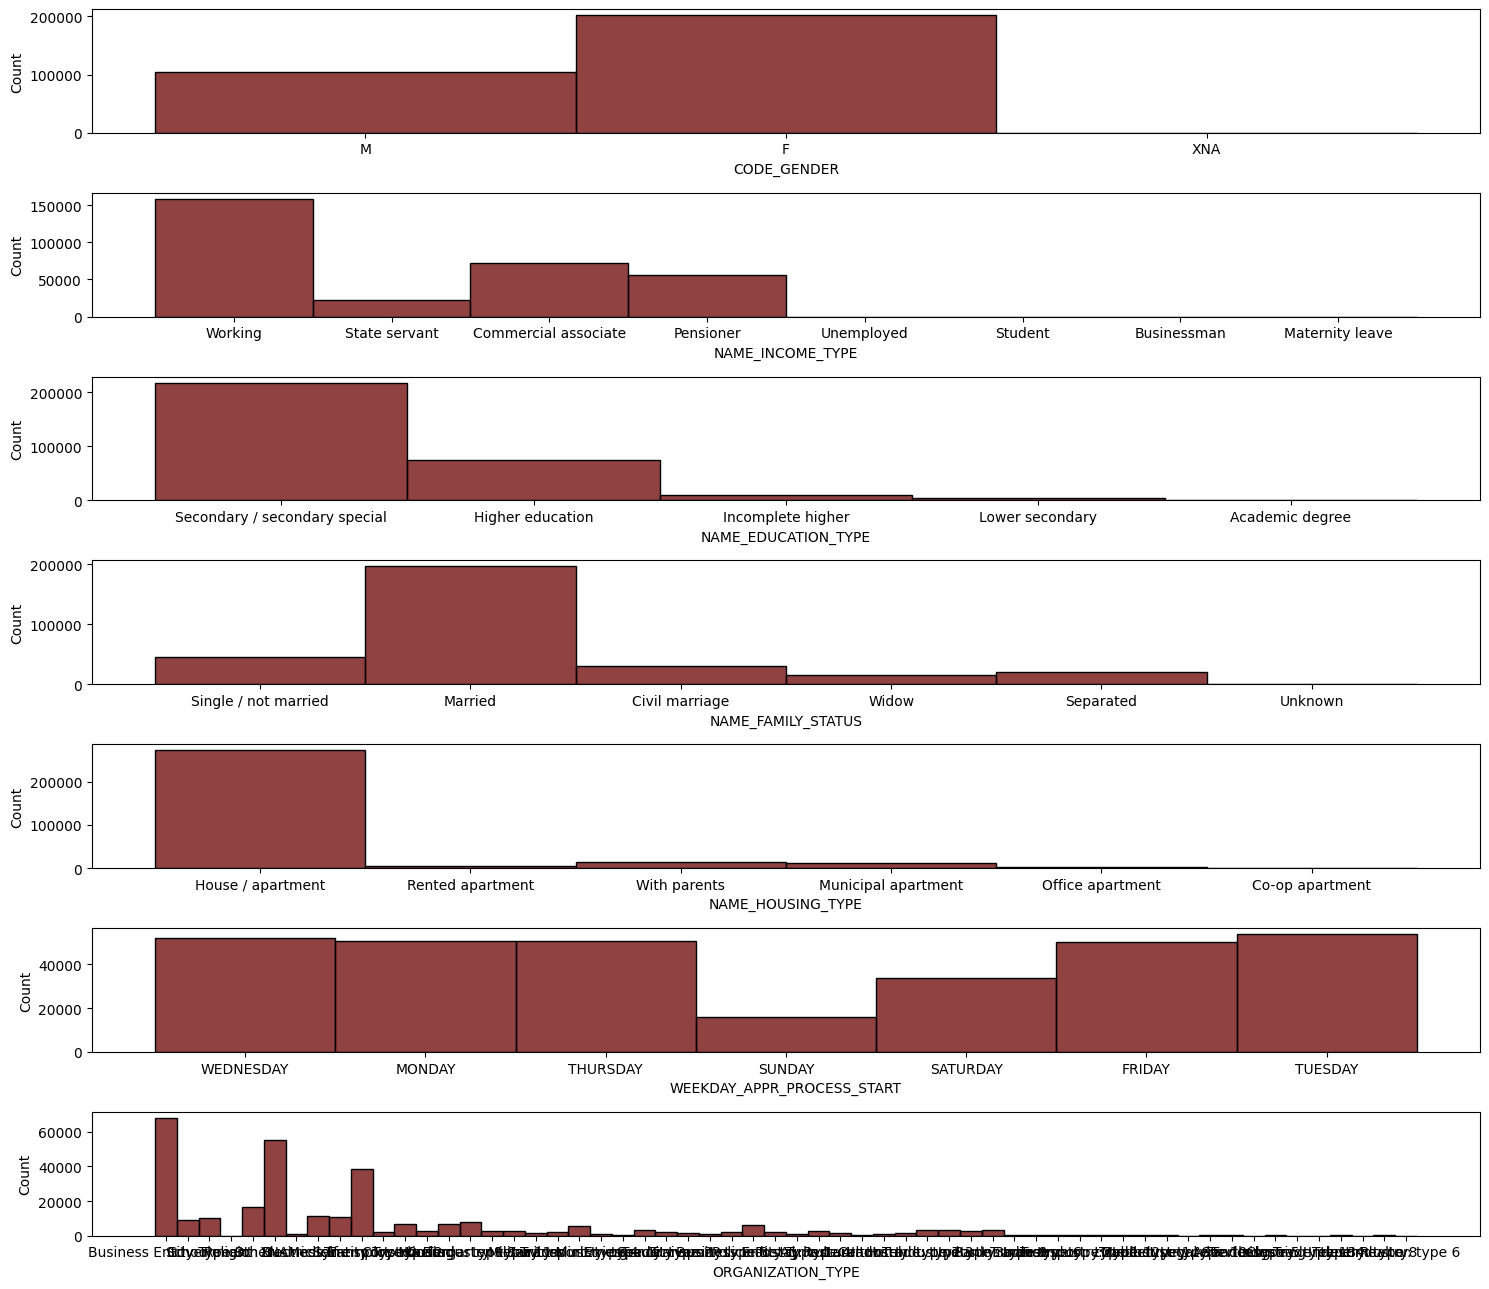

In [642]:
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1)
fig.set_size_inches(15, 13)

for i, col in enumerate(categorical_features):
    sns.histplot(data[col], kde=False, ax=axes[i], color='#6b0101')

plt.tight_layout()
plt.show()

### Побудуємо гістограми для числових значень 

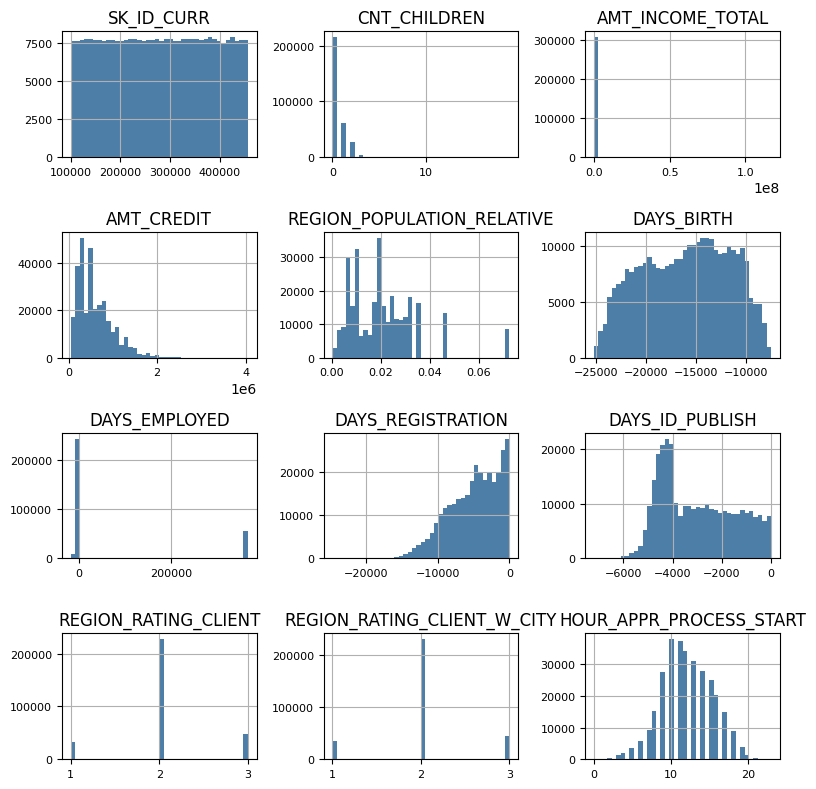

In [643]:
data[numerical_features].hist(figsize=(8, 8), bins=40, color='#4d7ea8', xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

Дані незбалансовані

### Побудуємо діаграми для булевих значень

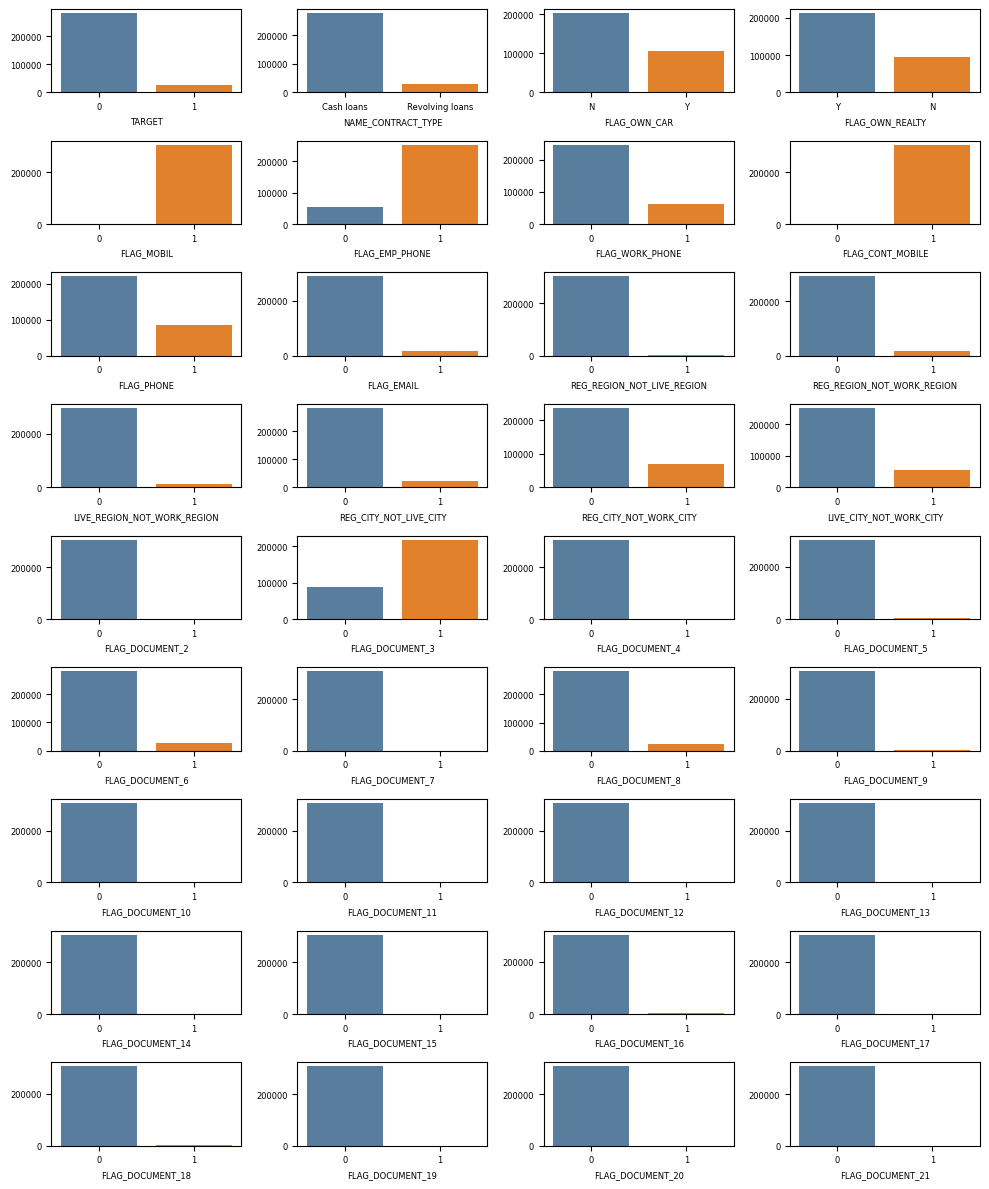

In [644]:
plt.figure(figsize=(10, 12))

for i, col in enumerate(boolean_features):
    ax = plt.subplot(len(boolean_features)//4 + (len(boolean_features)%4), 4, i + 1)
    sns.countplot(x=col, data=data, palette=['#4d7ea8', '#ff7f0e'], ax=ax)
    ax.set(ylabel=None)
    plt.xticks(fontsize=6) 
    plt.yticks(fontsize=6)  
    plt.xlabel(col, fontsize=6) 

plt.tight_layout()
plt.show()

#### Візуалізуємо викиди (outliers)

У boxplot головна лінія відображає медіанне значення, ліва та права межі представляють третій та перший квартилі (25% та 75%), а 'вуси' показують розмах даних. Точки, що виходять за вуси, є викидами

Наприклад, із графіків видно, що дані HOUR_APPR_PROCESS_START і DAYS_BIRTH розподілені майже рівномірно і містять відносно небагато (або зовсім не містять) викидів. 
Дані CNT_CHILDREN є переважно нулем чи одиницею, з невеликою кількістю цілочисельних (int) викидів. 
Дані AMT_CREDIT та DAYS_REGISTRATION містять велику кількість викидів.

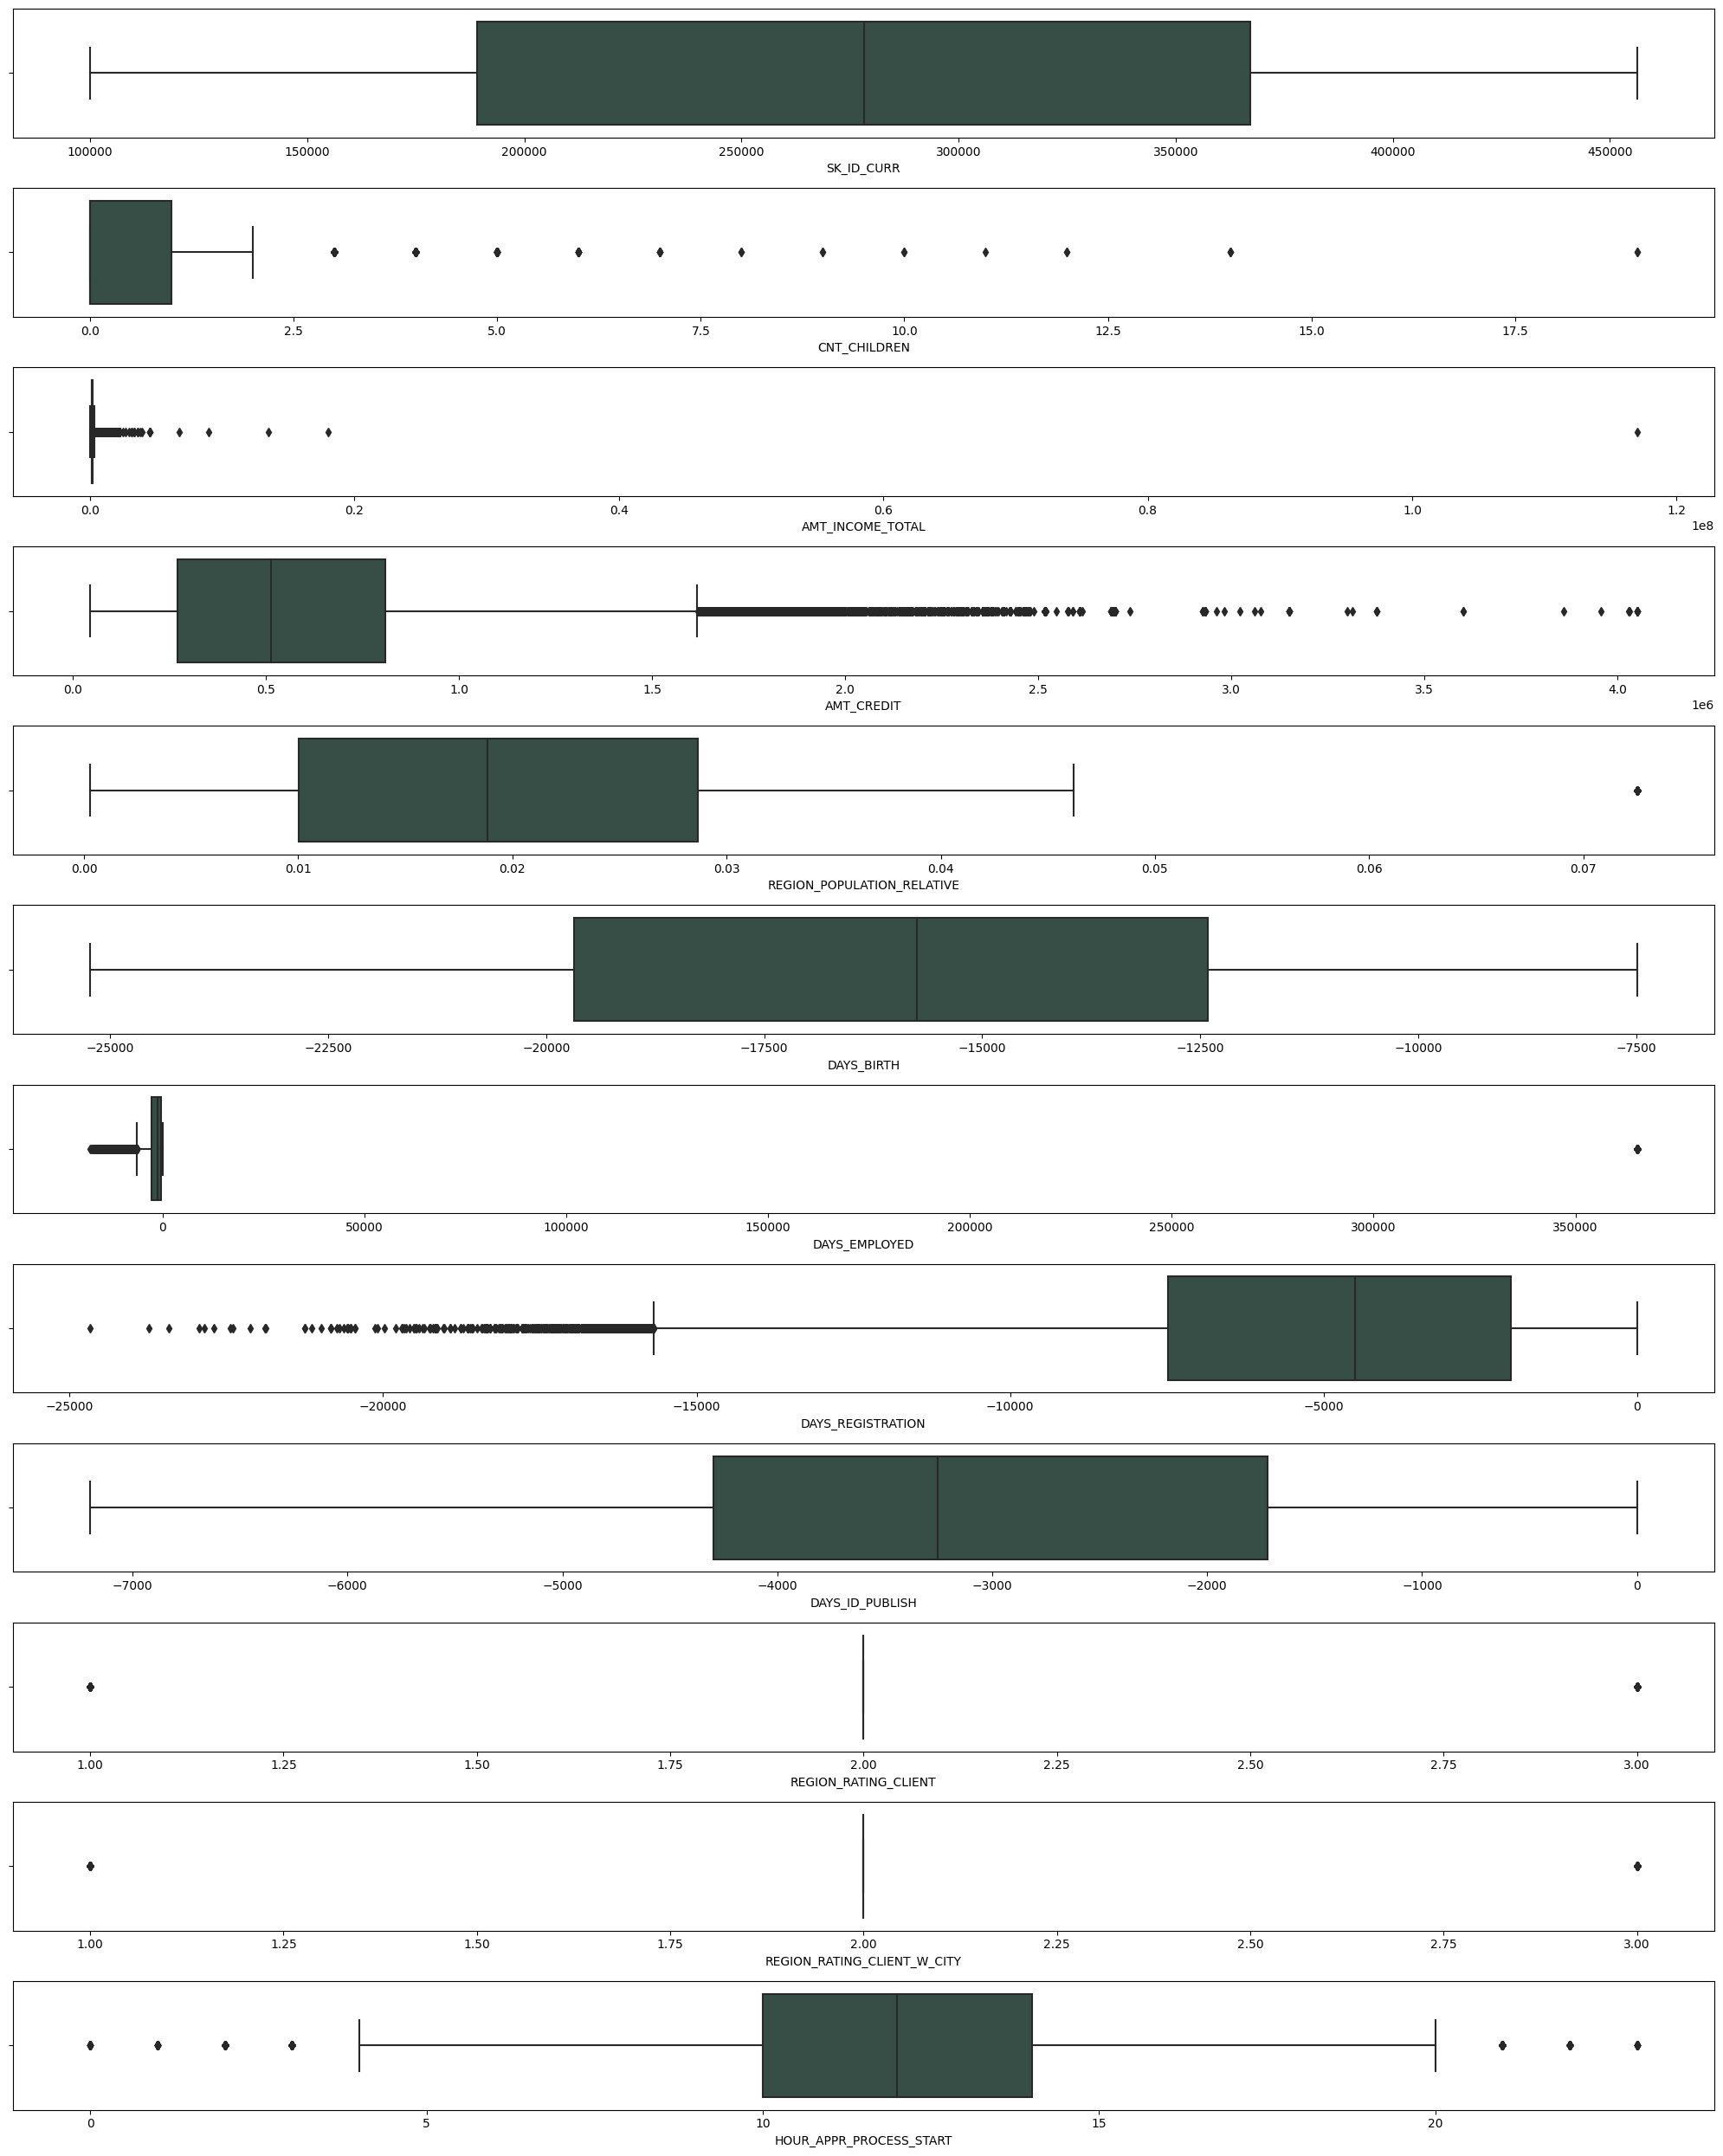

In [645]:
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1)
fig.set_size_inches(20,25)

for i, col in enumerate(numerical_features):
    sns.boxplot(x=data[col], ax=axes[i], color = '#335247')
    
fig.tight_layout()
plt.show()

#### Побудуємо Heatmap для числових даних 

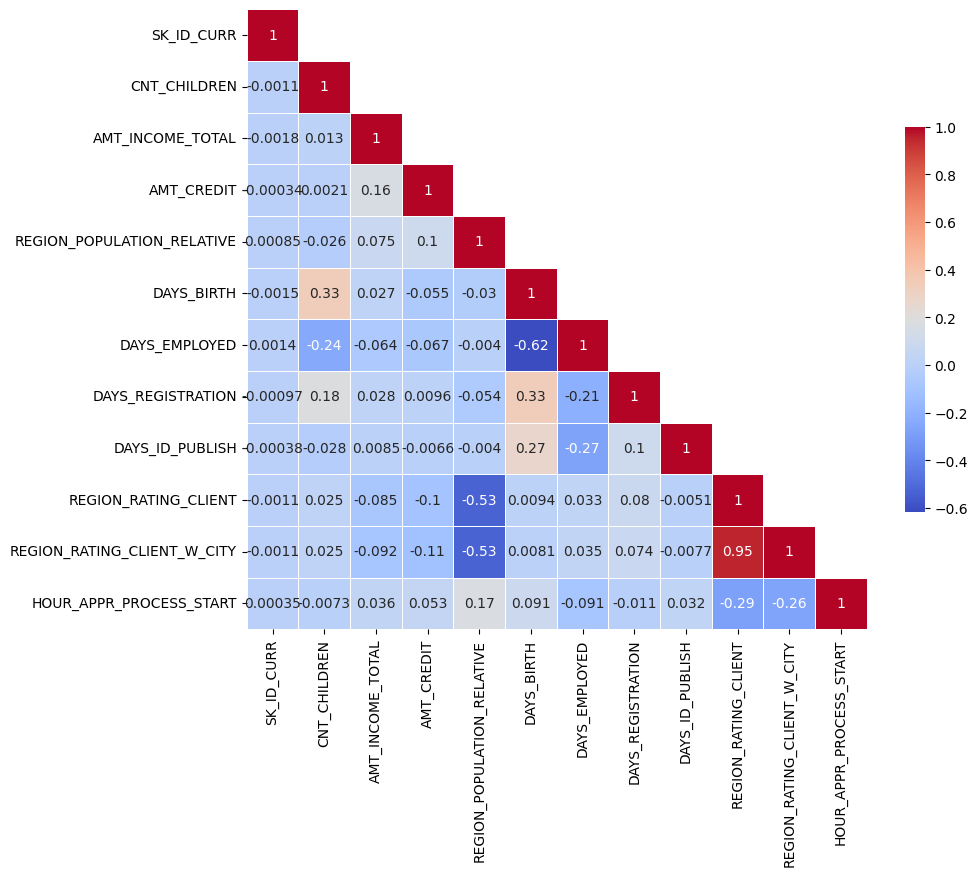

In [646]:
corr_matrix = data[numerical_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corr_matrix, cmap='coolwarm', mask=mask, vmax=1, square=True, annot=True,
            linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Аналогічно розглянемо тестові дані

In [647]:
#test_data.describe()
#test_data.describe(include='all')
#test_data.info()
#test_data.median()
#test_data.mean()
test_data.sample(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
4988,136009,Cash loans,F,N,Y,0,112500.0,415107.0,20097.0,346500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
22986,267113,Cash loans,F,Y,N,0,135000.0,450000.0,25258.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
32344,335397,Cash loans,F,Y,Y,0,225000.0,752116.5,42124.5,688500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


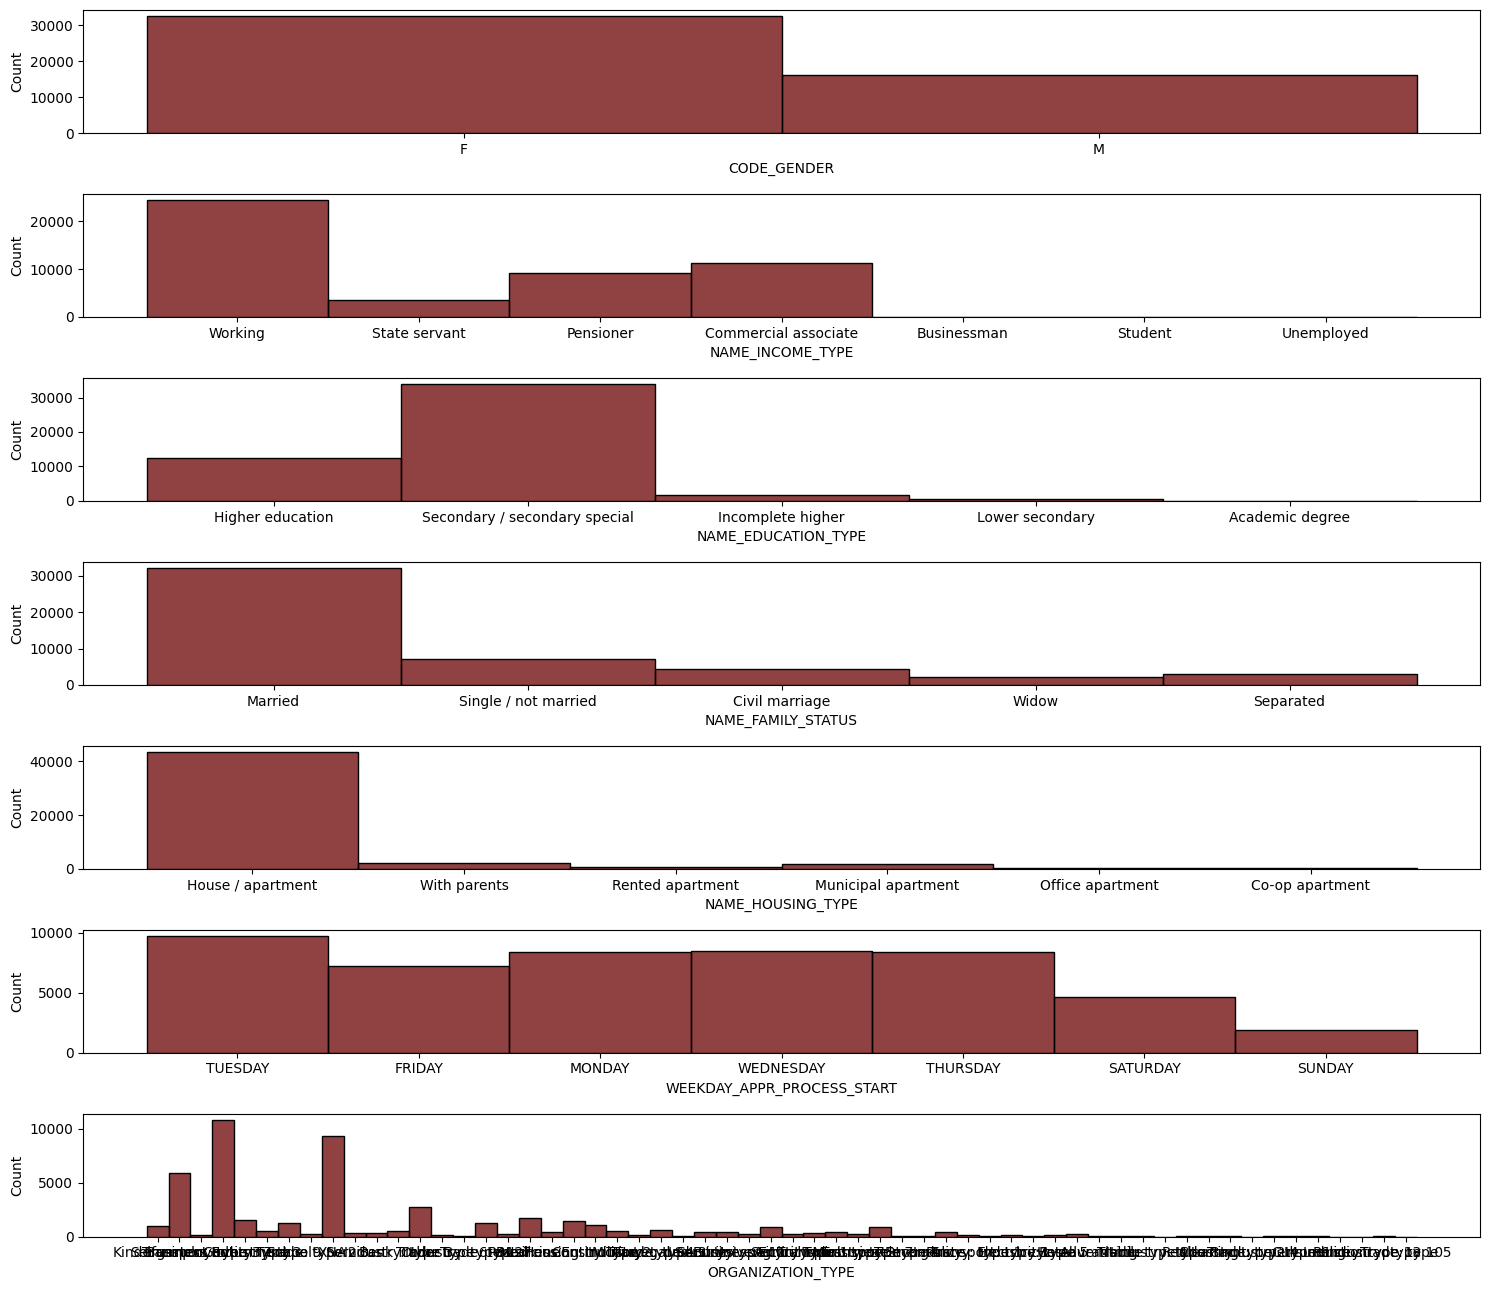

In [648]:
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1)
fig.set_size_inches(15, 13)

for i, col in enumerate(categorical_features):
    sns.histplot(test_data[col], kde=False, ax=axes[i], color='#6b0101')

plt.tight_layout()
plt.show()

#NUMERICAL
# data[numerical_features].hist(figsize=(8, 8), bins=40, color='#4d7ea8', xlabelsize=8, ylabelsize=8)

# plt.tight_layout()
# plt.show()

#BOXPLOT
# fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1)
# fig.set_size_inches(20,25)

# for i, col in enumerate(numerical_features):
#     sns.boxplot(x=test_data[col], ax=axes[i], color = '#335247')
    
# fig.tight_layout()
# plt.show()

In [12]:
features_test = features.drop("TARGET")

test_data = test_data[features_test]
datatrain = data[features_test]

In [650]:
print((test_data.isnull().mean() * 100).sort_values(ascending=False).head())

SK_ID_CURR                     0.0
FLAG_DOCUMENT_8                0.0
LIVE_REGION_NOT_WORK_REGION    0.0
REG_CITY_NOT_LIVE_CITY         0.0
REG_CITY_NOT_WORK_CITY         0.0
dtype: float64


In [14]:
boolean_features_list = list(boolean_features)
#boolean_features_list.remove('TARGET')
boolean_features = pd.Index(boolean_features_list)

transformer = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('categorical', OneHotEncoder(), categorical_features),
        ('boolean', OneHotEncoder(), boolean_features)
    ],
)
train_transformed = transformer.fit_transform(datatrain)
train_transformed = pd.DataFrame(train_transformed)

test_transformed = transformer.transform(test_data)
test_transformed = pd.DataFrame(test_transformed)

In [17]:
X_train = train_transformed
y_train = data['TARGET']

train_split_x, validate_x, train_split_y, validate_y = train_test_split(X_train, y_train, test_size=0.25)

In [22]:
lr = LogisticRegression(class_weight = "balanced", max_iter=100)

lr.fit(train_split_x, train_split_y)
train_predictions = lr.predict(train_split_x)
validate_predictions = lr.predict(validate_x)
    
train_accuracy = accuracy_score(train_split_y, train_predictions)
train_roc_auc = roc_auc_score(train_split_y, train_predictions)
validate_accuracy = accuracy_score(validate_y, validate_predictions)
validate_roc_auc = roc_auc_score(validate_y, validate_predictions)
    
print(f"Train accuracy:    {train_accuracy:.4f}\tROC_AUC: {train_roc_auc:.6f}")
print(f"Validate accuracy: {validate_accuracy:.4f}\tROC_AUC: {validate_roc_auc:.6f}")
    


lr.fit(train_split_x, train_split_y)
predictions = lr.predict(test_transformed)
    
result_df = pd.DataFrame({'Input': test_data.iloc[:, 0], 'Output': predictions})
output_file = 'C:\\Users\\Катя\\Desktop\\sample.csv'
result_df.to_csv(output_file, index=False)

C:\Users\Катя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy:    0.6205	ROC_AUC: 0.622783
Validate accuracy: 0.6157	ROC_AUC: 0.608413


C:\Users\Катя\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Модель показує приблизно однакові результати на тренувальних і валідаційних даних. Це може свідчити про те, що вона не перенавчена (overfitting) і не недонавчена (underfitting). Значення ROC-AUC, яке може коливатись від 0 до 1, дещо вищі за випадковий вибір (за 0,5). Тобто модель має деяку здатність розділяти класи.